In [20]:
import numpy as np
import caiman as cm
from caiman.source_extraction import cnmf
from caiman.utils.utils import download_demo
from caiman.utils.visualization import inspect_correlation_pnr, nb_inspect_correlation_pnr
from caiman.motion_correction import MotionCorrect
from caiman.source_extraction.cnmf import params as params
from caiman.utils.visualization import plot_contours, nb_view_patches, nb_plot_contour
import matplotlib.pyplot as plt
import cv2

In [24]:
path = '/media/hillierlab/T7/Data/Experiment/2021/08.03/data/20210803-111139-Fluorescent-recording.tif'
fnames = [download_demo(path)]
#fnames = [download_demo('msCam13.avi')]
if 'dview' in locals():
    cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)

In [18]:
#read parametes from a json file

def totuple(a):
    try:
        return tuple(totuple(i) for i in a)
    except TypeError:
        return a

In [19]:
import json
f = open('MC_parameters.json','r')
data = json.load(f)
#convert Json arrays to tuples
for key in data:
    if isinstance(data[key], list):
        data[key] = totuple(data[key])
f.close()
#add fname to dict
data["fnames"] = fnames
print(data)

{'fr': 35, 'decay_time': 0.4, 'pw_rigid': False, 'max_shifts': (5, 5), 'gSig_filt': (3, 3), 'strides': (48, 48), 'overlaps': (24, 24), 'max_deviation_rigid': 3, 'border_nan': 'copy', 'fnames': ['/media/hillierlab/T7/Data/Experiment/2021/08.03/data/20210803-111139-Fluorescent-recording.tif']}


In [22]:
# dataset dependent parameters
frate = 35                       # movie frame rate
decay_time = 0.4                 # length of a typical transient in seconds

    # motion correction parameters
motion_correct = True    # flag for performing motion correction
pw_rigid = False         # flag for performing piecewise-rigid motion correction (otherwise just rigid)
gSig_filt = (3, 3)       # size of high pass spatial filtering, used in 1p data
max_shifts = (5, 5)      # maximum allowed rigid shift
strides = (48, 48)       # start a new patch for pw-rigid motion correction every x pixels
overlaps = (24, 24)      # overlap between pathes (size of patch strides+overlaps)
max_deviation_rigid = 3  # maximum deviation allowed for patch with respect to rigid shifts
border_nan = 'copy'      # replicate values along the boundaries

mc_dict = {
    'fnames': fnames,
    'fr': frate,
    'decay_time': decay_time,
    'pw_rigid': pw_rigid,
    'max_shifts': max_shifts,
    'gSig_filt': gSig_filt,
    'strides': strides,
    'overlaps': overlaps,
    'max_deviation_rigid': max_deviation_rigid,
    'border_nan': border_nan
    }

opts = params.CNMFParams(params_dict=mc_dict)

In [28]:
mc = MotionCorrect(fnames, dview=dview, **opts.get_group('motion'))
mc.motion_correct()

In [30]:
fname_mc = mc.fname_tot_els if pw_rigid else mc.fname_tot_rig
bord_px = np.ceil(np.max(np.abs(mc.shifts_rig))).astype(np.int)
bord_px = 0 if border_nan is 'copy' else bord_px
fname_new = cm.save_memmap(fname_mc, base_name='memmap_', order='C', border_to_0=bord_px)

<>:3: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:3: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_109397/2015853614.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bord_px = np.ceil(np.max(np.abs(mc.shifts_rig))).astype(np.int)
/tmp/ipykernel_109397/2015853614.py:3: SyntaxWarning: "is" with a literal. Did you mean "=="?
  bord_px = 0 if border_nan is 'copy' else bord_px


Exception: Input must be an ndarray, use load instead!

In [29]:
print(mc.fname_tot_rig)

[None]


<>:19: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:19: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_92061/3527417735.py:19: SyntaxWarning: "is" with a literal. Did you mean "=="?
  bord_px = 0 if border_nan is 'copy' else bord_px
/tmp/ipykernel_92061/3527417735.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bord_px = np.ceil(np.max(np.abs(mc.shifts_rig))).astype(np.int)


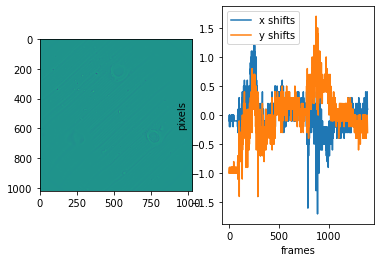

In [44]:
#Notebook motion correction
if motion_correct:
    # do motion correction rigid
    mc = MotionCorrect(fnames, dview=dview, **opts.get_group('motion'))
    #I could save the movie here as a mmap file
    mc.motion_correct(save_movie=True)
    fname_mc = mc.fname_tot_els if pw_rigid else mc.fname_tot_rig
    if pw_rigid:
        bord_px = np.ceil(np.maximum(np.max(np.abs(mc.x_shifts_els)),
                                     np.max(np.abs(mc.y_shifts_els)))).astype(np.int)
    else:
        bord_px = np.ceil(np.max(np.abs(mc.shifts_rig))).astype(np.int)
        plt.subplot(1, 2, 1); plt.imshow(mc.total_template_rig)  # % plot template
        plt.subplot(1, 2, 2); plt.plot(mc.shifts_rig)  # % plot rigid shifts
        plt.legend(['x shifts', 'y shifts'])
        plt.xlabel('frames')
        plt.ylabel('pixels')

    bord_px = 0 if border_nan is 'copy' else bord_px
    fname_new = cm.save_memmap(fname_mc, base_name='memmap_', order='C',
                               border_to_0=bord_px)
else:  # if no motion correction just memory map the file
    fname_new = cm.save_memmap(fnames, base_name='memmap_',
                               order='C', border_to_0=0, dview=dview)


In [26]:
"""
mc = MotionCorrect(fnames, dview=dview, **opts.get_group('motion'))
mc.motion_correct()
fname_mc = mc.fname_tot_els if pw_rigid else mc.fname_tot_rig
"""

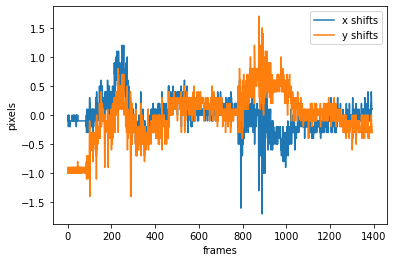

In [27]:
fig = plt.figure()
plt.plot(mc.shifts_rig)  # % plot rigid shifts
plt.legend(['x shifts', 'y shifts'])
plt.xlabel('frames')
plt.ylabel('pixels')
plt.show(block=True)
#plt.savefig('C:/Users/Martin/Desktop/Motion_correction_for/2recording.png')


In [45]:
#cm.concatenate((cm.load(fnames), cm.load(mc.mmap_file)), axis=0).play()
cm.load(mc.mmap_file).save("2.recording_motion corrected.tif")

100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


In [28]:
x_axis_elements = [x_shift[0] for x_shift in mc.shifts_rig]
y_axis_elements = [y_shift[1] for y_shift in mc.shifts_rig]

In [29]:
print("Max x oriented shift(px): ", np.max(x_axis_elements))
print("Max y oriented shift(px)? ", np.max(y_axis_elements))

print("Min x oriented shift(px): ", np.min(x_axis_elements))
print("Min y oriented shift(px)? ", np.min(y_axis_elements))


Max x oriented shift(px):  1.2
Max y oriented shift(px)?  1.7
Min x oriented shift(px):  -1.7
Min y oriented shift(px)?  -1.4
